In [374]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier , ExtraTreesClassifier


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')


In [375]:
#Importing data 
scoredf = pd.read_csv('creditscore.csv')
scoredf.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


In [376]:
#Removing unwanted characters
scoredf = scoredf.replace('_', '', regex=True)

In [377]:
#Checking for duplicates
scoredf['ID'].duplicated().sum()

0

In [378]:
scoredf['Customer_ID'].duplicated().sum()

87500

In [379]:
scoredf['Changed_Credit_Limit'].replace('', np.nan, inplace=True)

In [380]:

scoredf['Changed_Credit_Limit'] = scoredf['Changed_Credit_Limit'].astype(float)
scoredf['Changed_Credit_Limit'] = scoredf['Changed_Credit_Limit'].apply(lambda x: x if x >= 0 else 0)


In [381]:
scoredf['Changed_Credit_Limit'].isna().sum()

0

In [382]:
# scoredf.to_csv('credit.csv')

In [383]:
#Converting datatypes
scoredf['Age'] = scoredf['Age'].astype(int)
scoredf['Annual_Income'] = scoredf['Annual_Income'].astype(float)
scoredf['Monthly_Balance'] = scoredf['Monthly_Balance'].astype(float)
scoredf['Num_of_Delayed_Payment'] = scoredf['Num_of_Delayed_Payment'].astype(float)
scoredf['Outstanding_Debt'] = scoredf['Outstanding_Debt'].astype(float)


In [384]:
#Removing outliers
scoredf['Age'] =  scoredf['Age'][(scoredf['Age'] >= 0) & (scoredf['Age'] <= 100)]

In [385]:
scoredf['Age'].max()

100.0

In [386]:
#Defining functions
def replace_with_mode(df, group_col, target_col , new_col_name):
    mode_df = df.groupby(group_col)[target_col].agg(lambda x: x.mode().iloc[0] if not x.mode().iloc[0] == '' else np.nan ).reset_index()
    df = df.merge(mode_df, on=group_col, suffixes=('', '_mode'))
    df.rename(columns={f'{target_col}_mode': new_col_name}, inplace=True)
    df.drop(columns=[target_col], inplace=True)
    return df

In [387]:
#Filling missing values
user_mean_ages = scoredf.groupby('Customer_ID')['Age'].mean().round()
df_merged = scoredf.merge(user_mean_ages.rename('Mean_Age'), on='Customer_ID')
df_merged['Age'] = df_merged['Age'].fillna(df_merged['Mean_Age'])

scoredf = df_merged.drop(columns=['Mean_Age'])

In [388]:
#Replacing with mode
num_credit = scoredf.groupby('Customer_ID')['Num_Credit_Card'].min().reset_index()
mode_credit = scoredf.merge(num_credit, on='Customer_ID').rename(columns={'Num_Credit_Card_y': 'num_credit_cards'})
mode_credit.drop(columns=['Num_Credit_Card_x'], inplace=True)

In [389]:
#Replacing with mode
mode_credit = replace_with_mode(mode_credit, 'Customer_ID', 'Num_of_Loan' , 'num_of_loan')
mode_credit = replace_with_mode(mode_credit, 'Customer_ID', 'Num_Bank_Accounts' , 'num_bank_accounts')
mode_credit = replace_with_mode(mode_credit, 'Customer_ID', 'Interest_Rate' , 'interest_rate')
mode_credit = replace_with_mode(mode_credit, 'Customer_ID', 'Occupation' , 'occupation')
mode_credit = replace_with_mode(mode_credit, 'Customer_ID', 'Monthly_Inhand_Salary' , 'monthly_inhand_salary')


In [390]:
#Removing missing values
mode_credit.dropna(subset=['occupation'], inplace=True)

In [391]:
#Filling missing values
name = mode_credit['Name'].groupby(mode_credit['Customer_ID']).transform('first')
mode_credit['Name'] = mode_credit['Name'].fillna(name)


In [392]:
mode_credit['Monthly_Balance'] = mode_credit['Monthly_Balance'].dropna().apply(lambda x: x if x >= 0 else 0)
mode_credit = mode_credit[mode_credit['Delay_from_due_date'] >= 0]
mode_credit = mode_credit[mode_credit['Num_of_Delayed_Payment'] >= 0]


In [393]:
mode_credit.dropna(subset=['Monthly_Balance'], inplace=True)
mode_credit['Monthly_Balance'].isna().sum()

0

In [394]:
mode_credit['Monthly_Balance'].max()

1602.0405189622518

In [395]:
#Final dataframe
scoredf = mode_credit

# scoredf.columns = [col.lower() for col in scoredf.columns]

scoredf

,ID,Customer_ID,Month,Name,Age,SSN,Annual_Income,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,num_credit_cards,num_of_loan,num_bank_accounts,interest_rate,occupation,monthly_inhand_salary
0,0x1602,CUS0xd40,January,Aaron Maashoh,23.0,821-00-0265,19114.12,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7.0,...,80.41529543900253,HighspentSmallvaluepayments,312.494089,Good,4,4,3,3,Scientist,1824.843333
2,0x1604,CUS0xd40,March,Aaron Maashoh,23.0,821-00-0265,19114.12,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7.0,...,81.699521264648,LowspentMediumvaluepayments,331.209863,Good,4,4,3,3,Scientist,1824.843333
3,0x1605,CUS0xd40,April,Aaron Maashoh,23.0,821-00-0265,19114.12,"Auto Loan, Credit-Builder Loan, Personal Loan,...",5,4.0,...,199.4580743910713,LowspentSmallvaluepayments,223.451310,Good,4,4,3,3,Scientist,1824.843333
5,0x1607,CUS0xd40,June,Aaron Maashoh,23.0,821-00-0265,19114.12,"Auto Loan, Credit-Builder Loan, Personal Loan,...",8,4.0,...,62.430172331195294,!@9#%8,340.479212,Good,4,4,3,3,Scientist,1824.843333
6,0x1608,CUS0xd40,July,Aaron Maashoh,23.0,821-00-0265,19114.12,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,8.0,...,178.3440674122349,LowspentSmallvaluepayments,244.565317,Good,4,4,3,3,Scientist,1824.843333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,0x25fe8,CUS0x942c,March,Nicks,25.0,078-73-5990,39628.99,"Auto Loan, and Student Loan",20,6.0,...,140.58140274528395,HighspentMediumvaluepayments,410.256158,Poor,6,2,4,7,Mechanic,3359.415833
99995,0x25fe9,CUS0x942c,April,Nicks,25.0,078-73-5990,39628.99,"Auto Loan, and Student Loan",23,7.0,...,60.97133255718485,HighspentLargevaluepayments,479.866228,Poor,6,2,4,7,Mechanic,3359.415833
99996,0x25fea,CUS0x942c,May,Nicks,25.0,078-73-5990,39628.99,"Auto Loan, and Student Loan",18,7.0,...,54.18595028760385,HighspentMediumvaluepayments,496.651610,Poor,6,2,4,7,Mechanic,3359.415833
99997,0x25feb,CUS0x942c,June,Nicks,25.0,078-73-5990,39628.99,"Auto Loan, and Student Loan",27,6.0,...,24.02847744864441,HighspentLargevaluepayments,516.809083,Poor,6,2,4,7,Mechanic,3359.415833


In [396]:
print(scoredf['occupation'].unique())

['Scientist' 'Teacher' 'Engineer' 'Entrepreneur' 'Developer' 'Lawyer'
 'MediaManager' 'Doctor' 'Journalist' 'Manager' 'Accountant' 'Musician'
 'Mechanic' 'Writer' 'Architect']


## Data Visualization And EDA

In [397]:
y = scoredf['Credit_Score']
X = scoredf.drop('Credit_Score', axis=1)

X.fillna(0, inplace=True)

In [398]:
X_train, X_test, y_train, y_test = train_test_split(X, y , random_state=1 , test_size=0.2)
scoredf = pd.concat([X_train, y_train], axis=1)

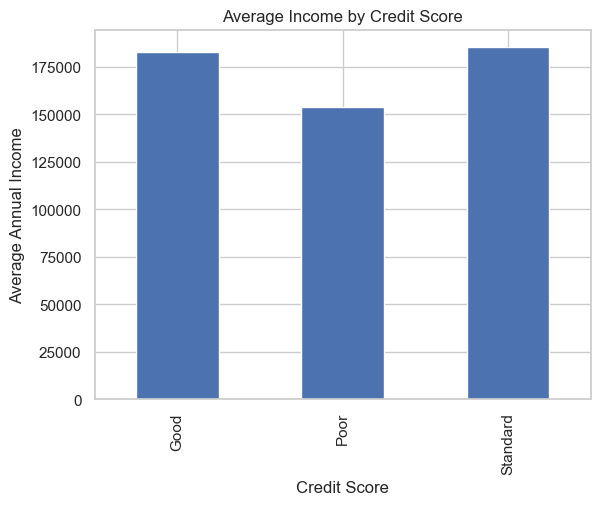

In [399]:

import matplotlib.pyplot as plt

scoredf.groupby('Credit_Score')['Annual_Income'].mean().plot(kind='bar', title='Average Income by Credit Score')
plt.xlabel('Credit Score')
plt.ylabel('Average Annual Income')
plt.show()





In [400]:
scoredf.columns

Index(['ID', 'Customer_ID', 'Month', 'Name', 'Age', 'SSN', 'Annual_Income',
       'Type_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment',
       'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Credit_Mix',
       'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance',
       'num_credit_cards', 'num_of_loan', 'num_bank_accounts', 'interest_rate',
       'occupation', 'monthly_inhand_salary', 'Credit_Score'],
      dtype='object')

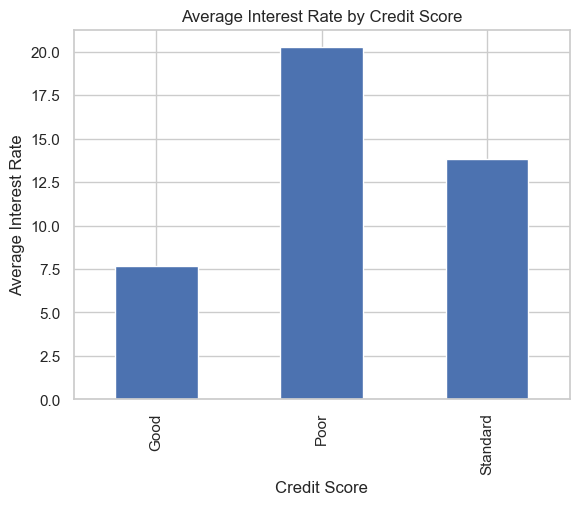

In [401]:
scoredf.groupby('Credit_Score')['interest_rate'].mean().plot(kind='bar', title='Average Interest Rate by Credit Score')
plt.xlabel('Credit Score')
plt.ylabel('Average Interest Rate')
plt.show()


In [402]:
scoredf['Credit_Score'] = scoredf['Credit_Score'].map({'Good': 1, 'Standard': 2, 'Poor': 3})
scoredf['Credit_Score']

55180    1
63518    1
64010    2
44538    2
35441    2
        ..
23669    1
80901    1
55220    3
5722     2
85715    2
Name: Credit_Score, Length: 72456, dtype: int64

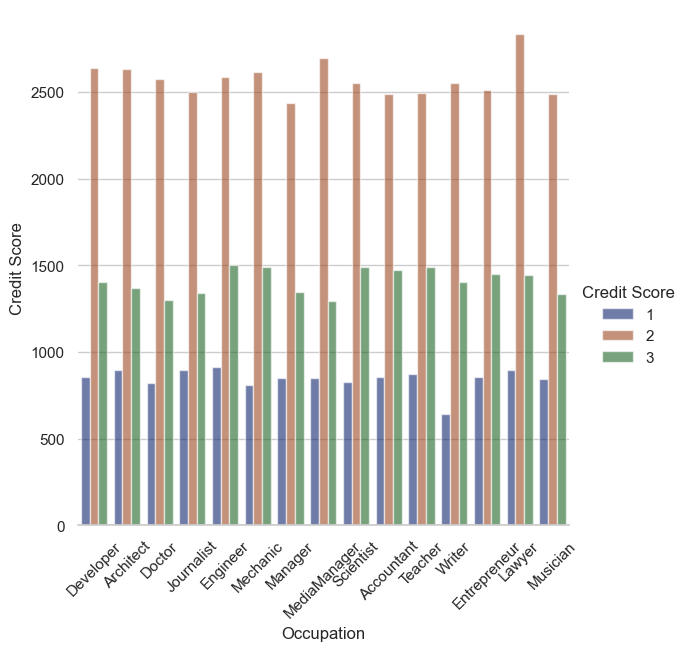

In [403]:

sns.set_theme(style="whitegrid")

g = sns.catplot(
    data=scoredf, kind="bar",
    x="occupation", y='Credit_Score', hue="Credit_Score",
    errorbar="sd", palette="dark", alpha=.6, height=6 , estimator='count' 
)
g.set_xticklabels(rotation=45)
g.despine(left=True)
g.set_axis_labels("Occupation", "Credit Score")
g.legend.set_title("Credit Score")



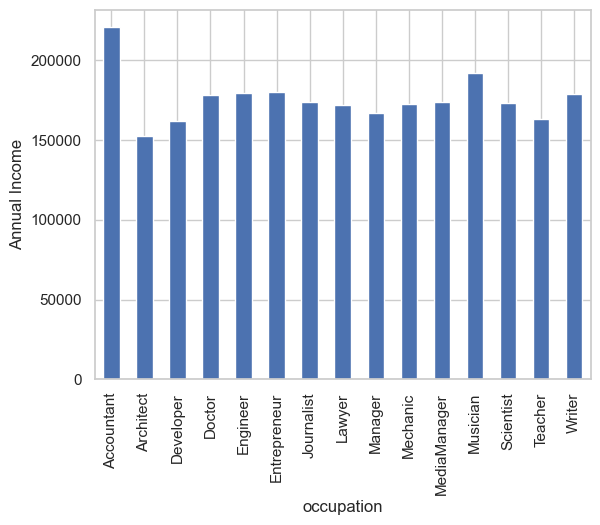

In [404]:


scoredf.groupby('occupation')['Annual_Income'].mean().plot(kind='bar')
plt.ylabel('Annual Income')
plt.show()


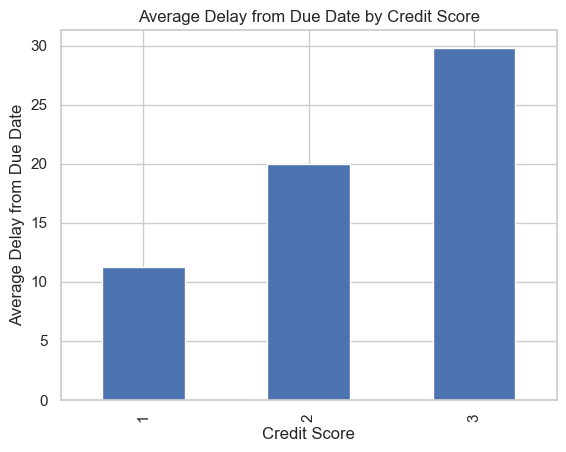

In [405]:
scoredf.groupby('Credit_Score')['Delay_from_due_date'].mean().plot(kind='bar', title='Average Delay from Due Date by Credit Score')
plt.xlabel('Credit Score')
plt.ylabel('Average Delay from Due Date')
plt.show()


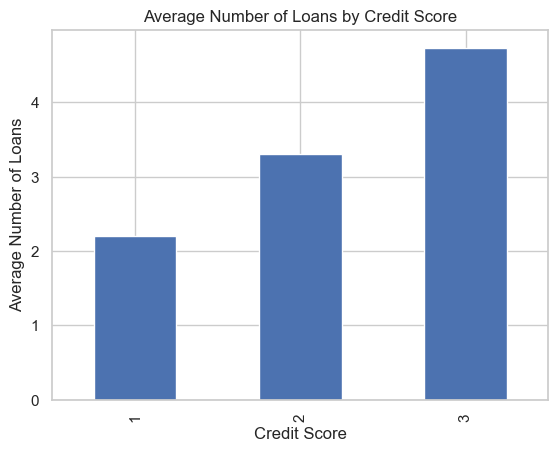

In [406]:
scoredf['num_of_loan'] = scoredf['num_of_loan'].astype(int)
avg_num_loans = scoredf.groupby('Credit_Score')['num_of_loan'].mean()
avg_num_loans.plot(kind='bar', title='Average Number of Loans by Credit Score')
plt.xlabel('Credit Score')
plt.ylabel('Average Number of Loans')
plt.show()

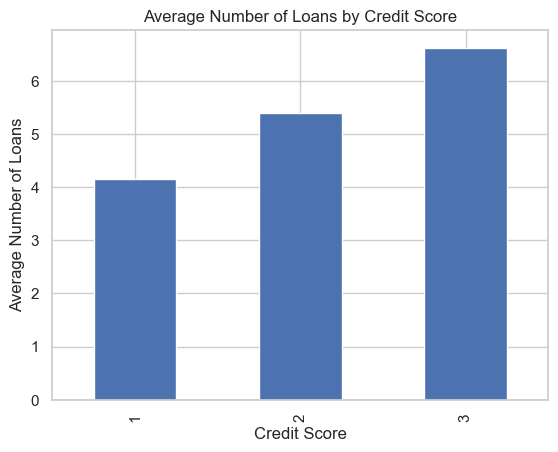

In [407]:
scoredf['num_of_loan'] = scoredf['num_credit_cards'].astype(int)
avg_num_loans = scoredf.groupby('Credit_Score')['num_of_loan'].mean()
avg_num_loans.plot(kind='bar', title='Average Number of Loans by Credit Score')
plt.xlabel('Credit Score')
plt.ylabel('Average Number of Loans')
plt.show()

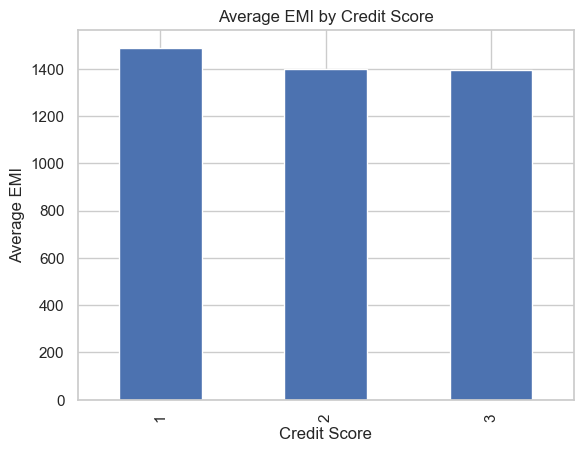

In [422]:

avg_emi = scoredf.groupby('Credit_Score')['Total_EMI_per_month'].mean()
avg_emi.plot(kind='bar', title='Average EMI by Credit Score')
plt.xlabel('Credit Score')
plt.ylabel('Average EMI')
plt.show()

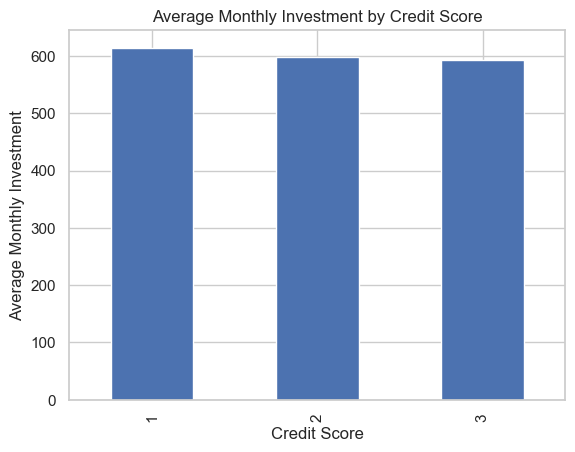

In [425]:
scoredf['Amount_invested_monthly'] = scoredf['Amount_invested_monthly'].astype(float)
avg_monthly_investment = scoredf.groupby('Credit_Score')['Amount_invested_monthly'].mean()
avg_monthly_investment.plot(kind='bar', title='Average Monthly Investment by Credit Score')
plt.xlabel('Credit Score')
plt.ylabel('Average Monthly Investment')
plt.show()

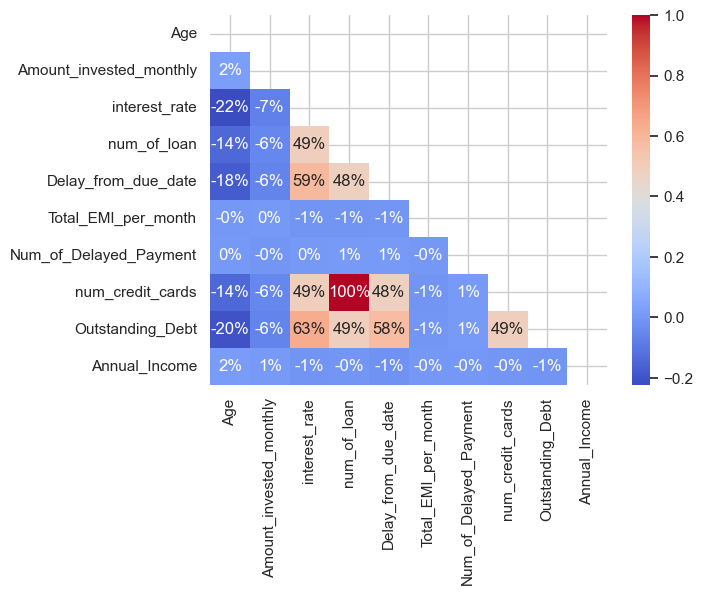

In [461]:


columns = [ 'Age' , 'Amount_invested_monthly' ,  'interest_rate' , 'num_of_loan'   , 'Delay_from_due_date' , 'Total_EMI_per_month'  , 'Num_of_Delayed_Payment'  , 'num_credit_cards' , 'Outstanding_Debt'  , 'Annual_Income' , ]

sns.heatmap(scoredf[columns].corr(), annot=True, cmap='coolwarm' ,square=False , mask=np.triu(scoredf[columns].corr()) , fmt='.0%')
plt.show()


##  Modeling

In [449]:
columns = [ 'Age'  , 'interest_rate' , 'num_of_loan'   , 'Delay_from_due_date' , 'Total_EMI_per_month'  , 'Num_of_Delayed_Payment' , 'Credit_Utilization_Ratio'  , 'Outstanding_Debt'  , 'Annual_Income' , ]




y = scoredf['Credit_Score']
X = scoredf.drop('Credit_Score', axis=1)

X.fillna(0, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y , random_state=1 , test_size=0.2)
scoredf = pd.concat([X_train, y_train], axis=1)


X_train = np.array(X_train[columns])
X_test = np.array(X_test[columns])

In [455]:
X_train[0]

array([4.00000000e+01, 2.30000000e+01, 1.00000000e+01, 5.40000000e+01,
       8.94231653e+01, 2.30000000e+01, 3.21127980e+01, 2.68637000e+03,
       1.63218200e+04])

## Loggistics Reggration

In [320]:
scoredf['occupation'] = scoredf['occupation'].map({'Scientist':1, 'Teacher':2, 'Engineer':3, 'Entrepreneur':4, 'Developer':5, 'Lawyer':6,
 'MediaManager':7, 'Doctor':8, 'Journalist':9, 'Manager':10, 'Accountant':11, 'Musician':12,
 'Mechanic':13, 'Writer':14, 'Architect':15})
scoredf['occupation']

55180     5
63518    15
64010     8
44538     9
35441     3
         ..
23669     1
80901    10
55220     9
5722     10
85715     7
Name: occupation, Length: 72456, dtype: int64

In [321]:
scoredf['Payment_of_Min_Amount'] = scoredf['Payment_of_Min_Amount'].map({'Yes': 1, 'No': 0 , 'NM' : 2})
scoredf['Payment_of_Min_Amount']

55180    0
63518    0
64010    1
44538    1
35441    1
        ..
23669    2
80901    0
55220    0
5722     1
85715    2
Name: Payment_of_Min_Amount, Length: 72456, dtype: int64

In [322]:
scoredf['Payment_of_Min_Amount'].isnull().sum()

0

In [323]:
scoredf['occupation'].isnull().sum()

0

In [326]:

clf = LogisticRegression()
clf.fit(X_train, y_train)



LogisticRegression()

In [327]:


train_accuracy = accuracy_score(y_train, clf.predict(X_train))
print(f"Train accuracy: {train_accuracy*100:.2f}")

Train accuracy: 53.29


In [328]:

p = clf.predict(X_test)


In [329]:


accuracy = accuracy_score(y_test, p)
print(f"Model accuracy: {accuracy*100:.2f}%")

Model accuracy: 53.71%


## Random Forest 


In [456]:
clf = RandomForestClassifier(n_estimators=150 , random_state=0)
clf.fit(X_train, y_train)


RandomForestClassifier(n_estimators=20, random_state=0)

In [457]:

train_accuracy = accuracy_score(y_train, clf.predict(X_train))
print(f"Train accuracy: {train_accuracy*100:.2f}")
p = clf.predict(X_test)
accuracy = accuracy_score(y_test, p)
print(f"Model accuracy: {accuracy*100:.2f}%")


Train accuracy: 99.57
Model accuracy: 72.81%


### Random Forest Hyperparameter Tuning

In [334]:
from sklearn.model_selection import GridSearchCV , RandomizedSearchCV 

In [335]:
param_grid = { 
	'n_estimators': [25, 50, 100, 150], 
	'max_features': ['sqrt', 'log2', None], 
	'max_depth': [3, 6, 9 , None], 
	
} 


In [336]:


# grid_search = GridSearchCV(RandomForestClassifier(), 
# 						param_grid=param_grid) 
# grid_search.fit(X_train, y_train) 
# print(grid_search.best_estimator_) 


In [337]:
# grid_search = RandomizedSearchCV(RandomForestClassifier(), 
# 						param_distributions=param_grid , cv=5 , n_jobs=-1 , n_iter=10) 
# grid_search.fit(X_train, y_train) 
# print(grid_search.best_estimator_) 

KeyboardInterrupt: 

In [441]:
clf = RandomForestClassifier(max_features=None, n_estimators=150, random_state=0 )
clf.fit(X_train, y_train)


RandomForestClassifier(max_features=None, n_estimators=150, random_state=0)

In [442]:
train_accuracy = accuracy_score(y_train, clf.predict(X_train))
print(f"Train accuracy: {train_accuracy*100:.2f}")

Train accuracy: 97.03


In [443]:
p = clf.predict(X_test)

In [444]:

accuracy = accuracy_score(y_test, p)

print(f"Model accuracy: {accuracy*100:.2f}%")

Model accuracy: 75.80%


##  AdaBoostClassifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
clf = AdaBoostClassifier( n_estimators=600, random_state=0 )
clf.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=600, random_state=0)

In [ ]:
train_accuracy = accuracy_score(y_train, clf.predict(X_train))
print(f"Train accuracy: {train_accuracy*100:.2f}")

p = clf.predict(X_test)

accuracy = accuracy_score(y_test, p)

print(f"Model accuracy: {accuracy*100:.2f}%")

Train accuracy: 64.68
Model accuracy: 64.35%


##  MLPClassifier

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
clf = MLPClassifier(max_iter=1000, tol=1e-8 , random_state=0 , verbose=True  , hidden_layer_sizes= (50,100 ) )
clf.fit(X_train, y_train)

Iteration 1, loss = 19.82080243
Iteration 2, loss = 19.15499842
Iteration 3, loss = 19.33074483
Iteration 4, loss = 18.87879559
Iteration 5, loss = 18.59911257
Iteration 6, loss = 18.39587632
Iteration 7, loss = 17.33433375
Iteration 8, loss = 18.03393298
Iteration 9, loss = 17.04451418
Iteration 10, loss = 16.97893426
Iteration 11, loss = 15.95251770
Iteration 12, loss = 15.49868070
Iteration 13, loss = 15.07488976
Iteration 14, loss = 14.98949175
Iteration 15, loss = 14.68795094
Iteration 16, loss = 13.09062502
Iteration 17, loss = 14.56579507
Iteration 18, loss = 12.80719311
Iteration 19, loss = 11.82525642
Iteration 20, loss = 11.93566825
Iteration 21, loss = 12.70628338
Iteration 22, loss = 10.64056149
Iteration 23, loss = 11.43349133
Iteration 24, loss = 10.15992764
Iteration 25, loss = 9.31835392
Iteration 26, loss = 8.95093422
Iteration 27, loss = 8.51217740
Iteration 28, loss = 9.49136717
Iteration 29, loss = 8.74342830
Iteration 30, loss = 7.61735102
Iteration 31, loss = 8.43

MLPClassifier(hidden_layer_sizes=(50, 100), max_iter=1000, random_state=0,
              tol=1e-08, verbose=True)

In [ ]:
train_accuracy = accuracy_score(y_train, clf.predict(X_train))
print(f"Train accuracy: {train_accuracy*100:.2f}")

p = clf.predict(X_test)

accuracy = accuracy_score(y_test, p)

print(f"Model accuracy: {accuracy*100:.2f}%")

Train accuracy: 57.54
Model accuracy: 58.43%


## ExtraTreesClassifier

In [447]:
clf = ExtraTreesClassifier(max_features=None, n_estimators=200, random_state=0)
clf.fit(X_train, y_train)

ExtraTreesClassifier(max_features=None, n_estimators=200, random_state=0)

In [448]:
train_accuracy = accuracy_score(y_train, clf.predict(X_train))
print(f"Train accuracy: {train_accuracy*100:.2f}")

p = clf.predict(X_test)

accuracy = accuracy_score(y_test, p)

print(f"Model accuracy: {accuracy*100:.2f}%")

Train accuracy: 97.03
Model accuracy: 75.42%


##  Feature Selection

In [416]:
from sklearn.feature_selection import SelectFromModel

In [417]:
selector = SelectFromModel(clf).fit(X_train, y_train)

In [418]:
X_train_selected = selector.transform(X_train)

X_test_selected = selector.transform(X_test)


In [419]:
X_train_selected

array([[6.00000e+00, 1.90000e+01, 8.00000e+00, 1.05265e+03],
       [1.00000e+00, 0.00000e+00, 1.00000e+01, 1.03280e+02],
       [1.20000e+01, 3.00000e+00, 1.10000e+01, 2.26980e+02],
       ...,
       [5.00000e+00, 1.60000e+01, 2.20000e+01, 1.07584e+03],
       [1.60000e+01, 2.60000e+01, 1.60000e+01, 5.60410e+02],
       [3.00000e+00, 1.10000e+01, 6.00000e+00, 1.18175e+03]])

In [420]:
clf = RandomForestClassifier(n_estimators=150 , random_state=0)
clf.fit(X_train_selected, y_train)

RandomForestClassifier(n_estimators=150, random_state=0)

In [421]:
train_accuracy = accuracy_score(y_train, clf.predict(X_train_selected))
print(f"Train accuracy: {train_accuracy*100:.2f}")
p = clf.predict(X_test_selected)
accuracy = accuracy_score(y_test, p)
print(f"Model accuracy: {accuracy*100:.2f}%")

Train accuracy: 93.83
Model accuracy: 73.74%
